In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN,LSTM,Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [2]:
df = pd.read_excel("D:\\Projects\\BDA\\aircraft_reliability\\data\\PM_train.xlsx")

In [3]:
df_truth = pd.read_excel("D:\\Projects\\BDA\\aircraft_reliability\\data\\PM_truth.xlsx")

In [4]:
df_merged = pd.merge(df, df_truth, on='id')
df_merged

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,more
0,1,1,-0.0007,-0.0004,100,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100,39.06,23.4190,98
1,1,2,0.0019,-0.0003,100,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100,39.00,23.4236,98
2,1,3,-0.0043,0.0003,100,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100,38.95,23.3442,98
3,1,4,0.0007,0.0000,100,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100,38.88,23.3739,98
4,1,5,-0.0019,-0.0002,100,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100,38.90,23.4044,98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20426,99,181,-0.0015,-0.0001,100,518.67,643.72,1600.39,1428.03,14.62,...,2388.29,8123.55,8.4885,0.03,396,2388,100,38.50,23.0425,20
20427,99,182,-0.0027,-0.0003,100,518.67,643.52,1605.33,1430.32,14.62,...,2388.27,8130.99,8.5124,0.03,393,2388,100,38.39,22.9674,20
20428,99,183,-0.0031,-0.0003,100,518.67,643.96,1606.95,1427.90,14.62,...,2388.31,8126.90,8.5374,0.03,395,2388,100,38.57,23.1440,20
20429,99,184,-0.0010,-0.0001,100,518.67,644.10,1600.20,1436.54,14.62,...,2388.33,8125.66,8.5592,0.03,395,2388,100,38.45,23.0478,20


In [5]:
# Step 1: Get the maximum cycle for each engine
max_cycle_per_engine = df.groupby('id')['cycle'].max().reset_index()
max_cycle_per_engine.columns = ['id', 'max_cycle']

# Step 2: Merge the maximum cycle with the df_truth to get the actual failure cycle
df_merged = pd.merge(max_cycle_per_engine, df_truth, on='id')

# Step 3: Calculate the actual failure cycle (when engine will fail)
df_merged['failure_cycle'] = df_merged['max_cycle'] + df_merged['more']

# Step 4: Merge this back with the main DataFrame to compute remaining cycles
df = pd.merge(df, df_merged[['id', 'failure_cycle']], on='id')

# Step 5: Calculate remaining cycles for each row by subtracting the current cycle from the failure cycle
df['remaining_cycles'] = df['failure_cycle'] - df['cycle']
df = df.drop('failure_cycle',axis=1)

In [6]:
data= df.copy()

In [7]:
def create_sequences(data, sequence_length, downsample=1):
    """
    Creates sequences of given length, with optional downsampling.
    
    Parameters:
    - data: DataFrame containing the data
    - sequence_length: The length of the sequences
    - downsample: Factor by which to downsample within the sequence
    
    Returns:
    - List of sequences (each sequence is an array of shape [sequence_length, features])
    - List of corresponding remaining_cycles (targets for each sequence)
    """
    sequences = []
    targets = []

    # Group by 'id' to handle each engine separately
    for engine_id in data['id'].unique():
        engine_data = data[data['id'] == engine_id]

        # Loop through each cycle to create sequences
        for i in range(len(engine_data) - sequence_length + 1):
            # Extract the sequence and downsample if required
            sequence = engine_data.iloc[i:i + sequence_length].iloc[::downsample]
            target = engine_data['remaining_cycles'].iloc[i + sequence_length - 1]
            
            sequences.append(sequence.drop(columns=['id', 'cycle', 'remaining_cycles']).values)
            targets.append(target)
    
    return np.array(sequences), np.array(targets)

# Short-term sequences (no downsampling)
short_term_sequences, short_term_targets = create_sequences(data, sequence_length=10, downsample=1)

# Medium-term sequences (downsample by a factor of 5 to reduce length)
medium_term_sequences, medium_term_targets = create_sequences(data, sequence_length=50, downsample=5)

# Check shapes
print("Short-term sequences shape:", short_term_sequences.shape)
print("Short-term targets shape:", short_term_targets.shape)
print("Medium-term sequences shape:", medium_term_sequences.shape)
print("Medium-term targets shape:", medium_term_targets.shape)

Short-term sequences shape: (19540, 10, 24)
Short-term targets shape: (19540,)
Medium-term sequences shape: (15580, 10, 24)
Medium-term targets shape: (15580,)


In [8]:
import pandas as pd
import numpy as np

# Define function to create sequences for different scales
def create_aligned_sequences(data, short_term_len, medium_term_len, downsample=1):
    short_term_sequences = []
    medium_term_sequences = []
    targets = []

    for engine_id in data['id'].unique():
        engine_data = data[data['id'] == engine_id]

        # Minimum range to allow both short- and medium-term sequences to fit
        max_start = len(engine_data) - max(short_term_len, medium_term_len) + 1

        for i in range(max_start):
            # Short-term sequence (no downsampling)
            short_sequence = engine_data.iloc[i:i + short_term_len]
            # Medium-term sequence with downsampling
            medium_sequence = engine_data.iloc[i:i + medium_term_len].iloc[::downsample]

            # Ensure the lengths are as expected
            if len(short_sequence) == short_term_len and len(medium_sequence) == (medium_term_len // downsample):
                short_term_sequences.append(short_sequence.drop(columns=['id', 'cycle', 'remaining_cycles']).values)
                medium_term_sequences.append(medium_sequence.drop(columns=['id', 'cycle', 'remaining_cycles']).values)
                # Target at the end of the sequence
                targets.append(engine_data['remaining_cycles'].iloc[i + short_term_len - 1])

    return np.array(short_term_sequences), np.array(medium_term_sequences), np.array(targets)

# Generate aligned sequences
short_term_sequences, medium_term_sequences, targets = create_aligned_sequences(
    data, short_term_len=10, medium_term_len=50, downsample=5
)


# Check shapes
print("Short-term sequences shape:", short_term_sequences.shape)
print("Short-term targets shape:", short_term_targets.shape)
print("Medium-term sequences shape:", medium_term_sequences.shape)
print("Medium-term targets shape:", medium_term_targets.shape)


Short-term sequences shape: (15580, 10, 24)
Short-term targets shape: (19540,)
Medium-term sequences shape: (15580, 10, 24)
Medium-term targets shape: (15580,)


In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Concatenate, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Define the model
def create_rnn_model(input_shape_short, input_shape_medium):
    short_input = Input(shape=input_shape_short)
    medium_input = Input(shape=input_shape_medium)

    # Short-term branch
    short_lstm = LSTM(64, return_sequences=True)(short_input)
    short_lstm = Dropout(0.2)(short_lstm)
    short_lstm = LSTM(32)(short_lstm)

    # Medium-term branch
    medium_lstm = LSTM(64, return_sequences=True)(medium_input)
    medium_lstm = Dropout(0.2)(medium_lstm)
    medium_lstm = LSTM(32)(medium_lstm)

    # Concatenate branches
    merged = Concatenate()([short_lstm, medium_lstm])
    dense = Dense(32, activation='relu')(merged)
    output = Dense(1)(dense)  # Output layer for RUL prediction

    model = tf.keras.Model(inputs=[short_input, medium_input], outputs=output)
    return model

# Create the model
input_shape_short = (10, 24)  # Example shape for short-term sequences
input_shape_medium = (10, 24)  # Example shape for medium-term sequences
model = create_rnn_model(input_shape_short, input_shape_medium)

In [10]:
initial_learning_rate = 0.00001
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)
model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mae'])

# Set up early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,         # Stop after 10 epochs of no improvement
    restore_best_weights=True  # Restore the best weights at the end
)

In [11]:
from sklearn.model_selection import train_test_split

# Get unique engine IDs
engine_ids = data['id'].unique()

# Split engine IDs into training and testing sets (e.g., 80% train, 20% test)
train_ids, test_ids = train_test_split(engine_ids, test_size=0.2, random_state=42)

# Filter data for train and test sets
train_data = data[data['id'].isin(train_ids)]
test_data = data[data['id'].isin(test_ids)]


In [12]:
# Generate sequences for training
short_term_train, medium_term_train, train_targets = create_aligned_sequences(
    train_data, short_term_len=10, medium_term_len=50, downsample=5
)

# Generate sequences for testing
short_term_test, medium_term_test, test_targets = create_aligned_sequences(
    test_data, short_term_len=10, medium_term_len=50, downsample=5
)


In [13]:
history = model.fit(
    [short_term_train, medium_term_train],
    train_targets,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping]  # Include the early stopping callback
)

Epoch 1/100
159/159 [==============================] - 12s 32ms/step - loss: 198.0874 - mae: 198.0874 - val_loss: 228.1256 - val_mae: 228.1256
Epoch 2/100
159/159 [==============================] - 3s 21ms/step - loss: 197.8755 - mae: 197.8755 - val_loss: 227.8974 - val_mae: 227.8974
Epoch 3/100
159/159 [==============================] - 3s 21ms/step - loss: 197.6676 - mae: 197.6676 - val_loss: 227.6855 - val_mae: 227.6855
Epoch 4/100
159/159 [==============================] - 3s 21ms/step - loss: 197.4519 - mae: 197.4519 - val_loss: 227.4574 - val_mae: 227.4574
Epoch 5/100
159/159 [==============================] - 3s 21ms/step - loss: 197.2122 - mae: 197.2122 - val_loss: 227.1967 - val_mae: 227.1967
Epoch 6/100
159/159 [==============================] - 3s 21ms/step - loss: 196.9388 - mae: 196.9388 - val_loss: 226.8984 - val_mae: 226.8984
Epoch 7/100
159/159 [==============================] - 3s 21ms/step - loss: 196.5982 - mae: 196.5982 - val_loss: 226.4777 - val_mae: 226.4777
Epoch

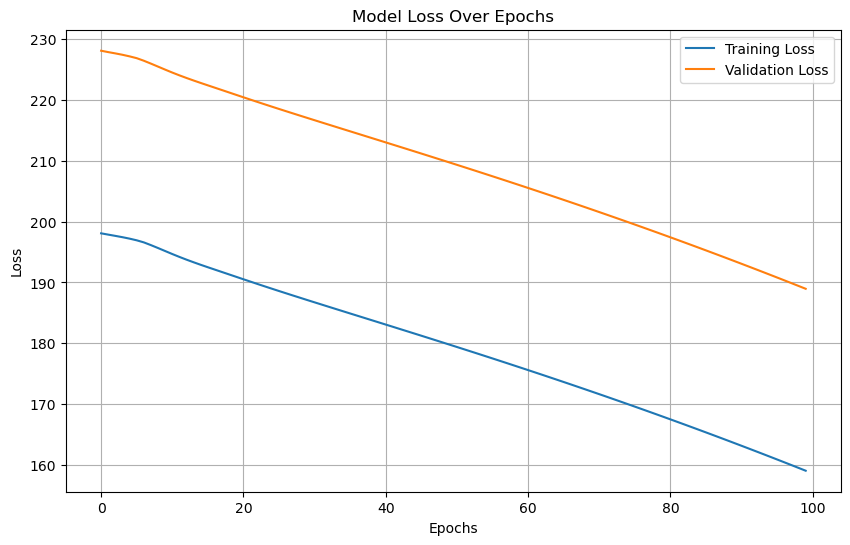

In [14]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Plot training & validation loss values
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function with your training history
plot_training_history(history)


92/92 [==============================] - 3s 6ms/step


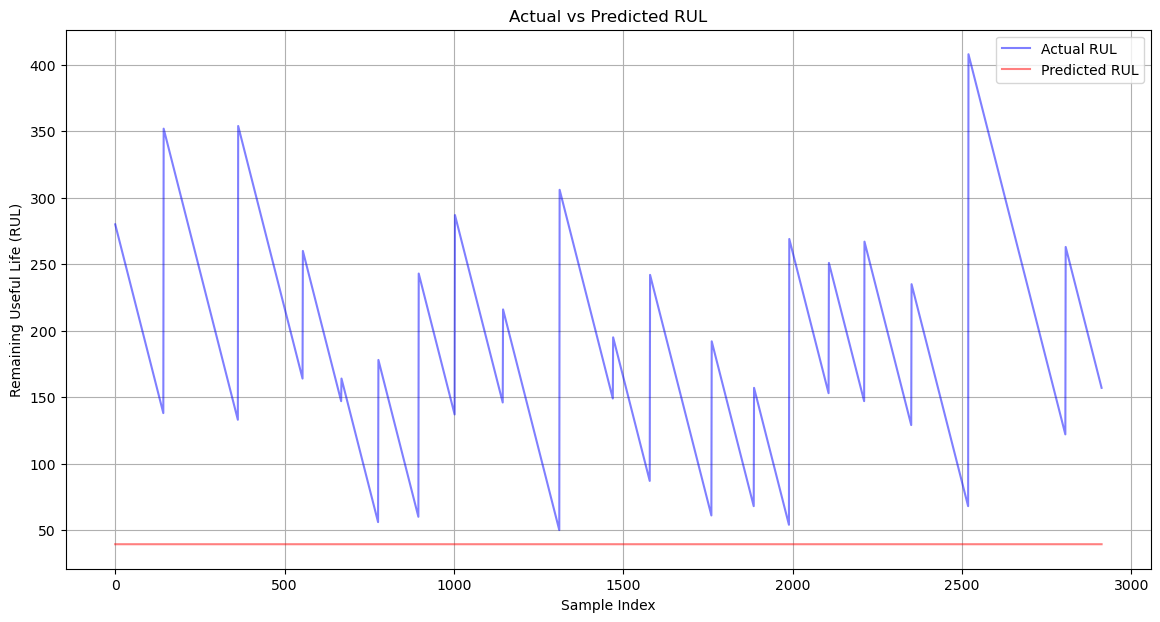

Sample predictions vs. actual RUL:
Predicted: 39.36, Actual: 280
Predicted: 39.36, Actual: 279
Predicted: 39.36, Actual: 278
Predicted: 39.36, Actual: 277
Predicted: 39.36, Actual: 276
Predicted: 39.36, Actual: 275
Predicted: 39.36, Actual: 274
Predicted: 39.36, Actual: 273
Predicted: 39.36, Actual: 272
Predicted: 39.36, Actual: 271


In [15]:
# Make predictions on the test set
predictions = model.predict([short_term_test, medium_term_test])

# If you want to compare predictions with actual targets
import numpy as np
import matplotlib.pyplot as plt

# Plotting the actual vs. predicted RUL
plt.figure(figsize=(14, 7))
plt.plot(test_targets, label='Actual RUL', color='blue', alpha=0.5)
plt.plot(predictions, label='Predicted RUL', color='red', alpha=0.5)
plt.title('Actual vs Predicted RUL')
plt.xlabel('Sample Index')
plt.ylabel('Remaining Useful Life (RUL)')
plt.legend()
plt.grid(True)
plt.show()

# Print out some of the predictions for inspection
print("Sample predictions vs. actual RUL:")
for i in range(10):
    print(f"Predicted: {predictions[i][0]:.2f}, Actual: {test_targets[i]}")


In [16]:
sample_indices = np.random.choice(len(predictions), size=10, replace=False)
print("Sample predictions:")
for i in sample_indices:
    print(f"Index: {i}, Predicted: {predictions[i][0]:.2f}")


Sample predictions:
Index: 2021, Predicted: 39.36
Index: 1442, Predicted: 39.36
Index: 1155, Predicted: 39.36
Index: 1231, Predicted: 39.36
Index: 578, Predicted: 39.36
Index: 1379, Predicted: 39.36
Index: 2672, Predicted: 39.36
Index: 163, Predicted: 39.36
Index: 110, Predicted: 39.36
Index: 509, Predicted: 39.36


In [17]:
print("Training Loss Values:", history.history['loss'])

Training Loss Values: [198.0874481201172, 197.87547302246094, 197.6676025390625, 197.45188903808594, 197.212158203125, 196.93875122070312, 196.59817504882812, 196.14688110351562, 195.6664581298828, 195.17340087890625, 194.68121337890625, 194.2074432373047, 193.75515747070312, 193.3245391845703, 192.90841674804688, 192.50685119628906, 192.11050415039062, 191.71524047851562, 191.32058715820312, 190.9253692626953, 190.52940368652344, 190.13778686523438, 189.74526977539062, 189.35934448242188, 188.97691345214844, 188.59596252441406, 188.21945190429688, 187.84426879882812, 187.4735870361328, 187.10037231445312, 186.7327423095703, 186.36563110351562, 185.99874877929688, 185.6320343017578, 185.2666778564453, 184.90023803710938, 184.53610229492188, 184.17152404785156, 183.8070831298828, 183.4415283203125, 183.075927734375, 182.71115112304688, 182.34312438964844, 181.97723388671875, 181.61053466796875, 181.24285888671875, 180.87425231933594, 180.50294494628906, 180.13258361816406, 179.760498046